In [0]:
import numpy as np
import pandas as pd 
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, LabelEncoder
from sklearn.model_selection import train_test_split
import xgboost as xgb
import lightgbm as lgb

In [0]:
X_train = pd.read_csv('https://raw.githubusercontent.com/sengatang/udacity_ml_nano/master/MLND_FINAL_Rossman/sales%20data/train.csv', parse_dates=[2], low_memory=False)
X_test = pd.read_csv('https://raw.githubusercontent.com/sengatang/udacity_ml_nano/master/MLND_FINAL_Rossman/sales%20data/test.csv', parse_dates=[3], low_memory=False)
store = pd.read_csv('https://raw.githubusercontent.com/sengatang/udacity_ml_nano/master/MLND_FINAL_Rossman/sales%20data/store.csv')

In [3]:
print(X_train["Date"].min(), X_train["Date"].max())
X_train.sort_values(["Date"], inplace=True, kind="mergesort")
X_train.reset_index(drop=True, inplace=True)

2013-01-01 00:00:00 2015-07-31 00:00:00


In [0]:
X_test['Open'].unique()
X_test["Open"] = X_test['Open'].fillna(1) # 将缺失的值补充为 1

In [0]:
store['CompetitionDistance'].fillna(store['CompetitionDistance'].median(), inplace = True)
store.fillna(0, inplace = True)

In [0]:
def get_processed_data_with_store(df, store):
  # 1. merge store
  df = pd.merge(df, store, on="Store", how="left")
  df['Year'] = df['Date'].dt.year
  df['Month'] = df['Date'].dt.month
  df['Day'] = df['Date'].dt.day
  df['DayOfYear'] = df['Date'].dt.dayofyear
  df['WeekOfYear'] = df['Date'].dt.weekofyear
  df.drop("Date", axis=1, inplace=True)
  df['CompetitionOpen'] = 12 * (df.Year - df.CompetitionOpenSinceYear) + \
          (df.Month - df.CompetitionOpenSinceMonth)
  df['CompetitionOpen'] = df.CompetitionOpen.apply(lambda x: x if x > 0 else 0)
  df['PromoOpen'] = 12 * (df.Year - df.Promo2SinceYear) + (df.WeekOfYear - df.Promo2SinceWeek) / 4.0
  df['PromoOpen'] = df['PromoOpen'].apply(lambda x: x if x > 0 else 0)
  month2str = {1:'Jan', 2:'Feb', 3:'Mar', 4:'Apr', 5:'May', 6:'Jun', 7:'Jul', 8:'Aug', 9:'Sept', 10:'Oct', 11:'Nov', 12:'Dec'}
  df['IsPromoMonth'] = 0
  df['MonthStr'] = df.Month.map(month2str)
  for interval in df.PromoInterval.unique():
    if interval != '' and type(interval)==str:
        for month in interval.split(','):
            df.loc[(df.MonthStr == month) & (df.PromoInterval == interval), 'IsPromoMonth'] = 1
  df.drop('MonthStr', axis=1, inplace=True)
  return df

def add_feature(df):
  avg_sale_per_store = X_train[["Store", "Sales", "Customers"]].groupby("Store").sum()
  avg_sale_per_store["AvgSalePerStore"] = avg_sale_per_store["Sales"] / avg_sale_per_store["Customers"]
  avg_sale_per_store.drop(['Sales', 'Customers'], axis=1, inplace=True)
  df = pd.merge(df, avg_sale_per_store, how="left", on="Store")

  groups = X_train[["Store", "Open"]].groupby("Store").mean()
  groups.rename(columns={"Open":"ShopAvgOpen"}, inplace=True)
  df = pd.merge(df, groups, how="left", on="Store")

  groups1 = X_train[["Store", "Sales"]].groupby("Store").sum()
  groups2 = X_train[X_train["StateHoliday"] != "0"][["Store", "Sales"]].groupby("Store").sum()
  groups = pd.merge(groups1, groups2, on="Store")
  groups["HolidayShopSales"] = groups["Sales_y"] / groups["Sales_x"]
  groups.drop(["Sales_x", "Sales_y"], axis=1, inplace=True)
  df = pd.merge(df, groups, how="left", on="Store")

  groups1 = X_train[["Store", "Sales"]].groupby("Store").sum()
  groups2 = X_train[X_train["IsPromoMonth"] == 1][["Store", "Sales"]].groupby("Store").sum()
  groups = pd.merge(groups1, groups2, on="Store")
  groups["PromoShopSales"] = groups["Sales_y"] / groups["Sales_x"]
  groups.drop(["Sales_x", "Sales_y"], axis=1, inplace=True)
  df = pd.merge(df, groups, how="left", on="Store")
  return df

In [0]:
X_train = get_processed_data_with_store(X_train, store)
X_test = get_processed_data_with_store(X_test, store)
X_train = add_feature(X_train)
X_test = add_feature(X_test)


In [0]:
test_close_ind = np.where(X_test["Open"] == 0)[0]
X_train = X_train[X_train["Sales"] != 0]
X_train.drop(["Open"], axis=1, inplace=True)
X_test.drop(["Open"], axis=1, inplace=True)

In [0]:
for col in ["StateHoliday", "StoreType", "Assortment", "DayOfWeek", "Month", "PromoInterval"]:
    for val in X_train[col].unique():
        new_col_name = col + "_" + str(val)
        X_train[new_col_name] = (X_train[col] == val).astype(int)
        X_test[new_col_name] = (X_test[col] == val).astype(int)
del X_train["PromoInterval"], X_test["PromoInterval"]

for col in ["StateHoliday", "StoreType", "Assortment"]:
    le = LabelEncoder()
    X_train[col] = le.fit_transform(X_train[col])
    X_test[col] = le.transform(X_test[col])

In [0]:
y_train = np.array(X_train["Sales"])
X_train.drop("Sales", axis=1, inplace=True)
X_train.drop("Customers", axis=1, inplace=True)
test_ID = X_test["Id"]
X_test.drop("Id", axis=1, inplace=True)

In [0]:
y_train = np.log1p(y_train)

In [0]:
def rmspe(y_true, y_pred):
    y_pred = y_pred[y_true != 0]
    y_true = y_true[y_true != 0]
    err = np.sqrt(np.mean((1 - y_pred / y_true) ** 2))
    return err

def rmspe_xgb(y_pred, y_true):
    y_true = y_true.get_label()
    err = rmspe(np.expm1(y_true), np.expm1(y_pred))
    return "rmspe", err

In [13]:
valid_mask = (X_train["Year"] == 2015) & (X_train["DayOfYear"] >= 171)
X_train_1, y_train_1 = X_train[~valid_mask], y_train[~valid_mask]
X_train_2, y_train_2 = X_train[valid_mask], y_train[valid_mask]
reg = xgb.XGBRegressor(n_estimators=5000, objective="reg:squarederror", max_depth=10,
                       learning_rate=0.03, colsample_bytree=0.7, subsample=0.9,
                       random_state=0, tree_method="gpu_hist")
reg.fit(X_train_1, y_train_1, eval_set=[(X_train_1, y_train_1), (X_train_2, y_train_2)],
        eval_metric=rmspe_xgb, early_stopping_rounds=100, verbose=100)
best_iteration = reg.best_iteration

[0]	validation_0-rmse:8.0208	validation_1-rmse:8.02753	validation_0-rmspe:0.999809	validation_1-rmspe:0.999811
Multiple eval metrics have been passed: 'validation_1-rmspe' will be used for early stopping.

Will train until validation_1-rmspe hasn't improved in 100 rounds.
[100]	validation_0-rmse:0.445049	validation_1-rmse:0.44999	validation_0-rmspe:0.354106	validation_1-rmspe:0.345255
[200]	validation_0-rmse:0.161075	validation_1-rmse:0.173896	validation_0-rmspe:0.205586	validation_1-rmspe:0.180458
[300]	validation_0-rmse:0.129715	validation_1-rmse:0.146825	validation_0-rmspe:0.174411	validation_1-rmspe:0.156482
[400]	validation_0-rmse:0.112373	validation_1-rmse:0.133352	validation_0-rmspe:0.154978	validation_1-rmspe:0.14218
[500]	validation_0-rmse:0.102011	validation_1-rmse:0.126068	validation_0-rmspe:0.143288	validation_1-rmspe:0.134588
[600]	validation_0-rmse:0.095485	validation_1-rmse:0.122267	validation_0-rmspe:0.134943	validation_1-rmspe:0.130369
[700]	validation_0-rmse:0.090322	

In [14]:
X_train, y_train = X_train[y_train != 0], y_train[y_train != 0]
reg = xgb.XGBRegressor(n_estimators=best_iteration, objective="reg:squarederror", max_depth=10,
                       learning_rate=0.03, colsample_bytree=0.7, subsample=0.9,
                       random_state=0, tree_method="gpu_hist")
reg.fit(X_train, y_train, eval_set=[(X_train, y_train)],
        eval_metric=rmspe_xgb, early_stopping_rounds=100, verbose=100)

[0]	validation_0-rmse:8.02111	validation_0-rmspe:0.999809
Multiple eval metrics have been passed: 'validation_0-rmspe' will be used for early stopping.

Will train until validation_0-rmspe hasn't improved in 100 rounds.
[100]	validation_0-rmse:0.444758	validation_0-rmspe:0.353499
[200]	validation_0-rmse:0.161195	validation_0-rmspe:0.200256
[300]	validation_0-rmse:0.129785	validation_0-rmspe:0.168512
[400]	validation_0-rmse:0.113178	validation_0-rmspe:0.150021
[500]	validation_0-rmse:0.102567	validation_0-rmspe:0.134289
[600]	validation_0-rmse:0.095952	validation_0-rmspe:0.125939
[700]	validation_0-rmse:0.0907	validation_0-rmspe:0.118542
[800]	validation_0-rmse:0.087042	validation_0-rmspe:0.11431
[900]	validation_0-rmse:0.084001	validation_0-rmspe:0.11025
[1000]	validation_0-rmse:0.081624	validation_0-rmspe:0.102826
[1100]	validation_0-rmse:0.07938	validation_0-rmspe:0.095269
[1200]	validation_0-rmse:0.077511	validation_0-rmspe:0.091722
[1300]	validation_0-rmse:0.07593	validation_0-rmsp

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.7, gamma=0,
             importance_type='gain', learning_rate=0.03, max_delta_step=0,
             max_depth=10, min_child_weight=1, missing=None, n_estimators=2108,
             n_jobs=1, nthread=None, objective='reg:squarederror',
             random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=None, silent=None, subsample=0.9, tree_method='gpu_hist',
             verbosity=1)

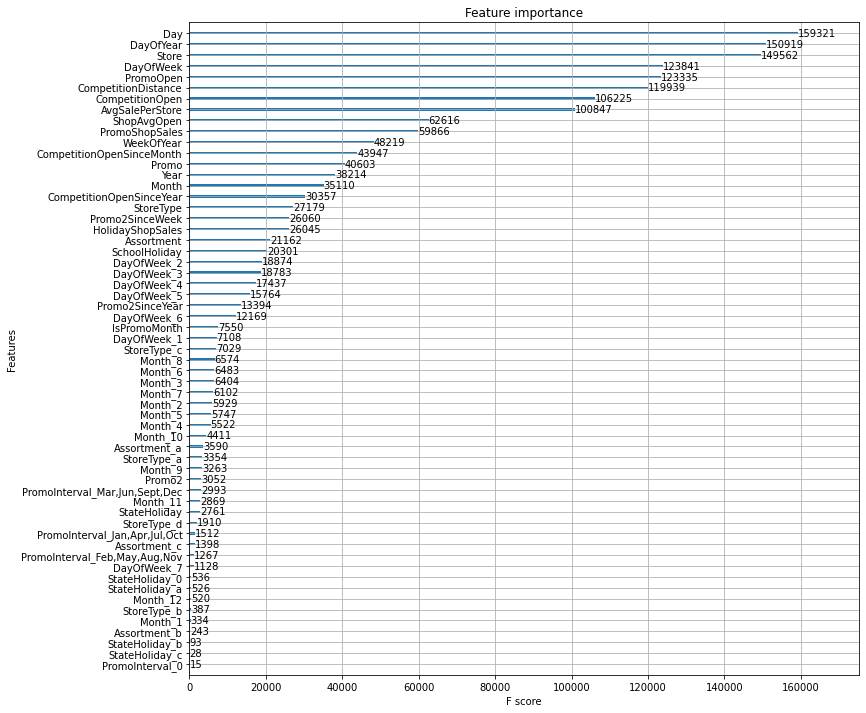

In [24]:
f, ax = plt.subplots(figsize = (12, 12))
xgb.plot_importance(reg, ax=ax)

In [0]:
pred = np.expm1(reg.predict(X_test))
pred[test_close_ind] = 0
submission = pd.DataFrame({"Id": test_ID, "Sales": pred}, columns=["Id", "Sales"])

submission.to_csv("submission.csv", index=False)

In [0]:
from google.colab import files
# files.download('submission.csv')

In [0]:
graph = xgb.to_graphviz(reg, num_trees=0, **{'size': str(10)})
graph.render(filename='xgb.dot')

'xgb.dot.pdf'

In [0]:
files.download('xgb.dot.pdf')

In [0]:
clf_e = xgb.XGBRegressor()
clf_e.fit(X_train,y_train)
print('XGboost',rmspe(clf_e.predict(X_test),y_test))

[15:11:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


NameError: ignored